## Configuration et Montage Google Drive

In [1]:
!pip install -q imutils
# Monter Google Drive
from google.colab import drive
# Imports
import os
import shutil
import time
from math import ceil

# Image processing
import cv2
import imutils
from tqdm import tqdm

# Data manipulation
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation,
    MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [27]:
drive.mount('/content/drive')
DATASET_BASE_PATH = '/content/drive/MyDrive/DATA'  # À MODIFIER
WORK_DIR = '/content/drive/MyDrive/Brain_Tumor_Detection_Results' # Define a working directory for models and logs
models_path = os.path.join(WORK_DIR, 'models') # Path for saving models

# Ensure WORK_DIR and models_path exist
os.makedirs(models_path, exist_ok=True)

# Paramètres
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
LABELS = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##  Fonctions Utilitaires

In [3]:
# ==================== HELPER FUNCTIONS ====================

def hms_string(sec_elapsed):
    """Convertit les secondes en format h:m:s"""
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s, 1)}"


def compute_f1_score(y_true, y_pred):
    """Calcule le F1-score macro"""
    score = f1_score(y_true, y_pred, average='macro')
    return score


def plot_confusion_matrix(y_true, y_pred, labels):
    """Affiche la matrice de confusion"""
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    plt.show()


def print_classification_report(y_true, y_pred, labels):
    """Affiche le rapport de classification"""
    print('\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=labels))


def plot_metrics(history):
    """Affiche les courbes de loss et accuracy"""
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy
    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [4]:
# ==================== IMAGE PROCESSING FUNCTIONS ====================

def extract_contour(image, display=False):
    """
    Extrait et recadre la région du cerveau en trouvant les contours extrêmes
    """
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Seuillage
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Trouver les contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Trouver les points extrêmes
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Recadrer l'image
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if display:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))
        plt.title('Cropped')
        plt.show()

    return new_image


def preprocess_image(image, size=256):
    """
    Prétraite une image: resize, normalisation, filtrage
    """
    # Redimensionner
    image = cv2.resize(image, dsize=(size, size), interpolation=cv2.INTER_CUBIC)

    # Normaliser
    image = image.astype(np.float32)
    image = (image - np.min(image)) / (np.max(image) - np.min(image))

    # Filtrage bilatéral pour réduire le bruit
    image = cv2.bilateralFilter(image, 2, 50, 50)

    # Reconvertir en uint8
    image = (image * 255).astype(np.uint8)

    return image


def load_data(dataset_path, labels, extract_contours=False, preprocess=True, img_size=256):
    """
    Charge les images depuis le dataset

    Args:
        dataset_path: Chemin vers Training/ ou Testing/
        labels: Liste des labels
        extract_contours: Si True, extrait les contours du cerveau
        preprocess: Si True, applique le prétraitement
        img_size: Taille finale des images
    """
    X = []
    y = []

    for label in labels:
        label_path = os.path.join(dataset_path, label)
        if not os.path.exists(label_path):
            print(f"WARNING: {label_path} n'existe pas!")
            continue

        files = [f for f in os.listdir(label_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        print(f"Chargement de {len(files)} images de {label}...")

        for filename in tqdm(files, desc=f"  {label}"):
            file_path = os.path.join(label_path, filename)
            image = cv2.imread(file_path)

            if image is None:
                continue

            # Extraire les contours si demandé
            if extract_contours:
                try:
                    image = extract_contour(image, display=False)
                except:
                    pass  # Si l'extraction échoue, utiliser l'image originale

            # Prétraiter si demandé
            if preprocess:
                image = preprocess_image(image, size=img_size)
            else:
                image = cv2.resize(image, (img_size, img_size))

            X.append(image)
            y.append(labels.index(label))

    X = np.array(X)
    y = np.array(y)

    # Mélanger les données
    X, y = shuffle(X, y, random_state=42)

    print(f"\nDonnées chargées: {len(X)} images")
    print(f"Shape: {X.shape}")

    return X, y

## Chargement et Exploration des Données

In [5]:
# Vérifier que le dataset existe
train_path = os.path.join(DATASET_BASE_PATH, 'Training')
test_path = os.path.join(DATASET_BASE_PATH, 'Testing')

print(f"Chemin Training: {train_path}")
print(f"Existe: {os.path.exists(train_path)}")
print(f"\nChemin Testing: {test_path}")
print(f"Existe: {os.path.exists(test_path)}")




Chemin Training: /content/drive/MyDrive/DATA/Training
Existe: True

Chemin Testing: /content/drive/MyDrive/DATA/Testing
Existe: True


In [6]:
# Statistiques du dataset
print("Distribution des classes:\n")
train_counts = {}
test_counts = {}

for label in LABELS:
    train_label_path = os.path.join(train_path, label)
    test_label_path = os.path.join(test_path, label)

    if os.path.exists(train_label_path):
        train_counts[label] = len([f for f in os.listdir(train_label_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    else:
        train_counts[label] = 0

    if os.path.exists(test_label_path):
        test_counts[label] = len([f for f in os.listdir(test_label_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
    else:
        test_counts[label] = 0

    print(f"{label:12} - Train: {train_counts[label]:4d}, Test: {test_counts[label]:4d}")

print(f"\nTotal Training: {sum(train_counts.values())}")
print(f"Total Testing:  {sum(test_counts.values())}")

Distribution des classes:

glioma_tumor - Train:  826, Test:  100
meningioma_tumor - Train:  822, Test:  115
no_tumor     - Train:  395, Test:  105
pituitary_tumor - Train:  827, Test:   74

Total Training: 2870
Total Testing:  394


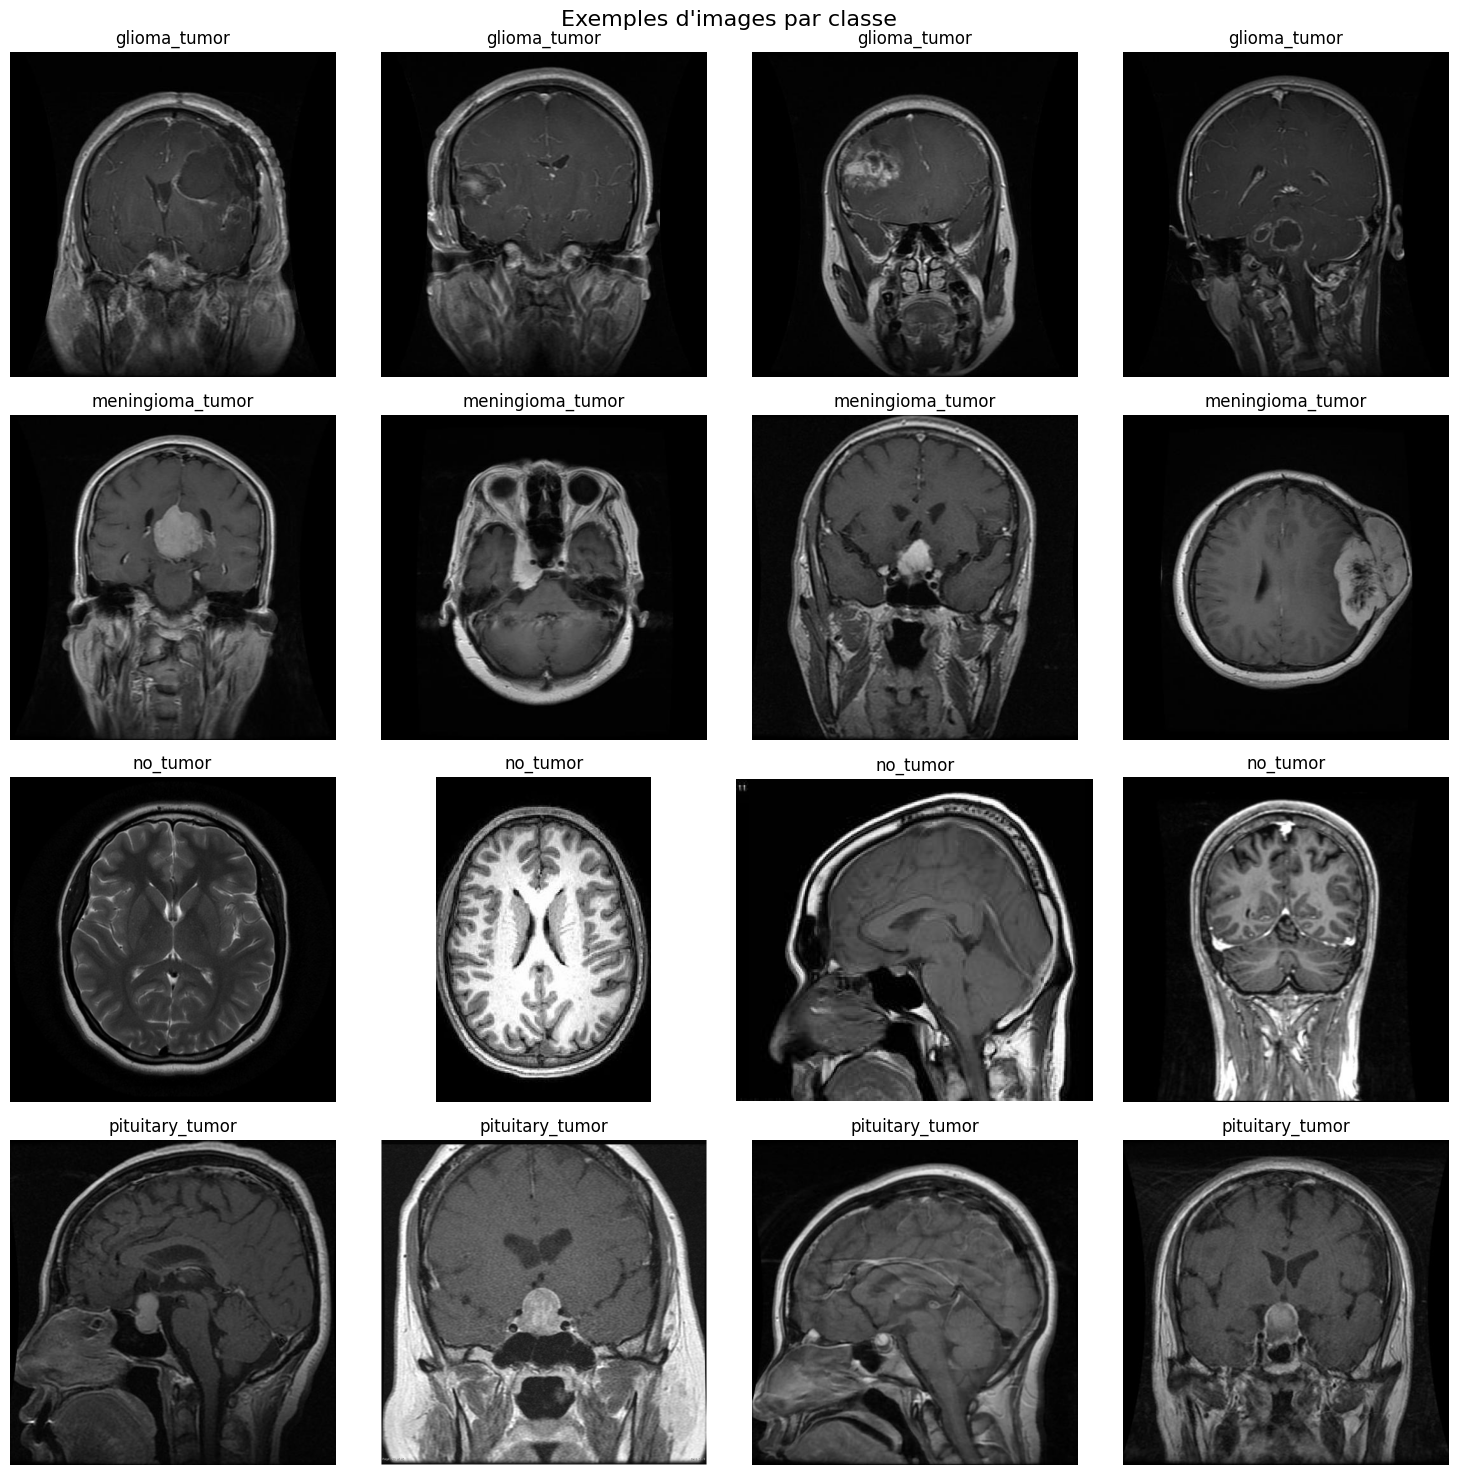

In [7]:
# Afficher quelques exemples d'images
fig, axes = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle('Exemples d\'images par classe', fontsize=16)

for idx, label in enumerate(LABELS):
    label_path = os.path.join(train_path, label)
    if os.path.exists(label_path):
        files = [f for f in os.listdir(label_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:4]

        for i, filename in enumerate(files):
            img_path = os.path.join(label_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[idx, i].imshow(img)
            axes[idx, i].set_title(label)
            axes[idx, i].axis('off')

plt.tight_layout()
plt.show()

Test sur: /content/drive/MyDrive/DATA/Training/glioma_tumor/gg (788).jpg



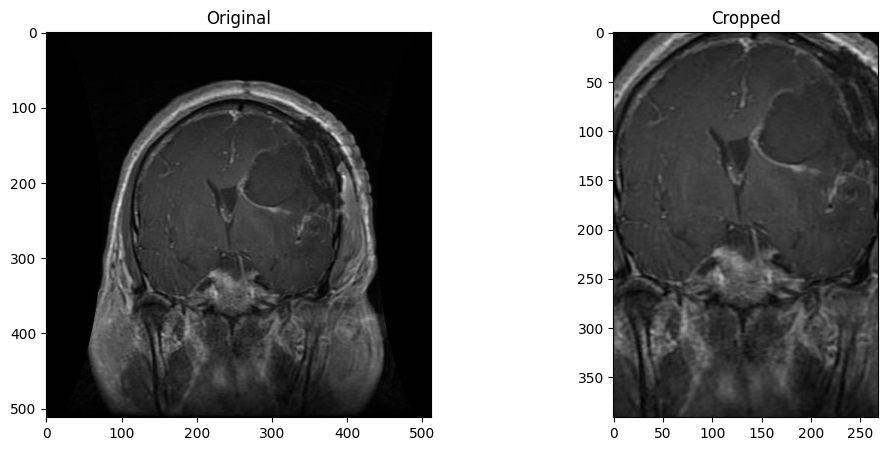

In [8]:
# Tester l'extraction de contours sur une image
sample_label = LABELS[0]
sample_files = [f for f in os.listdir(os.path.join(train_path, sample_label))
                if f.endswith(('.jpg', '.jpeg', '.png'))]
sample_path = os.path.join(train_path, sample_label, sample_files[0])

sample_img = cv2.imread(sample_path)
print(f"Test sur: {sample_path}\n")
cropped_img = extract_contour(sample_img, display=True)

##  Prétraitement et Chargement des Données

In [9]:
# Charger les données d'entraînement
print("Chargement des données d'entraînement...\n")
X_train_full, y_train_full = load_data(
    train_path,
    LABELS,
    extract_contours=True,  # Mettre False pour aller plus vite
    preprocess=True,
    img_size=IMG_SIZE
)

Chargement des données d'entraînement...

Chargement de 826 images de glioma_tumor...


  glioma_tumor: 100%|██████████| 826/826 [00:17<00:00, 48.21it/s]


Chargement de 822 images de meningioma_tumor...


  meningioma_tumor: 100%|██████████| 822/822 [00:19<00:00, 42.41it/s] 


Chargement de 395 images de no_tumor...


  no_tumor: 100%|██████████| 395/395 [00:03<00:00, 114.50it/s]


Chargement de 827 images de pituitary_tumor...


  pituitary_tumor: 100%|██████████| 827/827 [00:18<00:00, 45.71it/s] 



Données chargées: 2870 images
Shape: (2870, 256, 256, 3)


In [10]:
# Charger les données de test
print("\nChargement des données de test...\n")
X_test, y_test = load_data(
    test_path,
    LABELS,
    extract_contours=True,  # Mettre False pour aller plus vite
    preprocess=True,
    img_size=IMG_SIZE
)


Chargement des données de test...

Chargement de 100 images de glioma_tumor...


  glioma_tumor: 100%|██████████| 100/100 [00:02<00:00, 41.94it/s]


Chargement de 115 images de meningioma_tumor...


  meningioma_tumor: 100%|██████████| 115/115 [00:02<00:00, 49.31it/s] 


Chargement de 105 images de no_tumor...


  no_tumor: 100%|██████████| 105/105 [00:02<00:00, 48.34it/s] 


Chargement de 74 images de pituitary_tumor...


  pituitary_tumor: 100%|██████████| 74/74 [00:27<00:00,  2.65it/s]


Données chargées: 394 images
Shape: (394, 256, 256, 3)


In [11]:
# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.3,
    random_state=42,
    stratify=y_train_full
)

print(f"Training samples:   {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples:       {X_test.shape[0]}")
print(f"\nShape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")
print(f"Nombre de classes: {len(np.unique(y_train))}")

Training samples:   2009
Validation samples: 861
Test samples:       394

Shape: (2009, 256, 256, 3)
Labels shape: (2009,)
Nombre de classes: 4


In [12]:
# Créer le générateur d'augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

print("Générateur d'augmentation créé")

Générateur d'augmentation créé


##  Construction des Modèles

In [13]:
def CNN_MRI(input_shape, num_classes):
    """
    Modèle CNN simple baseline
    """
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Créer le modèle
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
CNN_MRI = CNN_MRI(IMG_SHAPE, len(LABELS))
CNN_MRI.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,078,212 (225.37 MB)

 Trainable params: 59,078,212 (225.37 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Callbacks communs
def get_callbacks(model_name):
    # TensorBoard
    log_dir = os.path.join(WORK_DIR, 'logs', f'{model_name}_{int(time.time())}')
    tensorboard = TensorBoard(log_dir=log_dir)

    # ModelCheckpoint
    checkpoint_path = os.path.join(models_path, f'{model_name}_best.h5')
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    return [tensorboard, checkpoint]

In [23]:
# Compiler le modèle
CNN_MRI.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entraîner
print("Entraînement du modèle Baseline...\n")
start_time = time.time()

history_baseline = CNN_MRI.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks('baseline_cnn'),
    verbose=1
)

elapsed = time.time() - start_time
print(f"\nTemps d'entraînement: {hms_string(elapsed)}")

Entraînement du modèle Baseline...

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.2929 - loss: 338.0121
Epoch 1: val_accuracy improved from -inf to 0.36353, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 684ms/step - accuracy: 0.2936 - loss: 333.9436 - val_accuracy: 0.3635 - val_loss: 1.2790
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.3421 - loss: 1.3133
Epoch 2: val_accuracy improved from 0.36353 to 0.39257, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 686ms/step - accuracy: 0.3422 - loss: 1.3131 - val_accuracy: 0.3926 - val_loss: 1.2636
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.3563 - loss: 1.2924
Epoch 3: val_accuracy did not improve from 0.39257
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 721ms/step - accuracy: 0.3563 - loss: 1.2927 - val_accuracy: 0.3763 - val_loss: 1.2859
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.3219 - loss: 1.2993
Epoch 4: val_accuracy did not improve from 0.39257
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 456ms/step - accuracy: 0.3223 - loss: 1.2993 - val_accuracy: 0.3868 - val_loss: 1.2742
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.3753 - loss: 1.2984
Epoch 5: val_accuracy improved from 0.39257 to 0.39837, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 714ms/step - accuracy: 0.3754 - loss: 1.2981 - val_accuracy: 0.3984 - val_loss: 1.2680
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.3935 - loss: 1.2796
Epoch 6: val_accuracy improved from 0.39837 to 0.40534, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 982ms/step - accuracy: 0.3931 - loss: 1.2795 - val_accuracy: 0.4053 - val_loss: 1.2593
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.4017 - loss: 1.2678
Epoch 7: val_accuracy did not improve from 0.40534
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 732ms/step - accuracy: 0.4016 - loss: 1.2677 - val_accuracy: 0.3844 - val_loss: 1.2670
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.3676 - loss: 1.2709
Epoch 8: val_accuracy did not improve from 0.40534
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 576ms/step - accuracy: 0.3678 - loss: 1.2709 - val_accuracy: 0.3705 - val_loss: 1.2692
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.3521 - loss: 1.2895
Epoch 9: val_accuracy did not improve from 0.40534
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 454ms/step - accuracy: 0.3525 - loss: 1.2891 - val_accuracy: 0.4007 - val_loss: 1.2618
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.4041 - loss: 1.2483
Epoch 10: val_accuracy did not

63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 793ms/step - accuracy: 0.3694 - loss: 1.2490 - val_accuracy: 0.4274 - val_loss: 1.2400
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.3801 - loss: 1.2802
Epoch 13: val_accuracy improved from 0.42741 to 0.43670, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.3804 - loss: 1.2798 - val_accuracy: 0.4367 - val_loss: 1.2555
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.4163 - loss: 1.2502
Epoch 14: val_accuracy did not improve from 0.43670
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 694ms/step - accuracy: 0.4163 - loss: 1.2501 - val_accuracy: 0.4286 - val_loss: 1.2328
Epoch 15/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.4194 - loss: 1.2524
Epoch 15: val_accuracy improved from 0.43670 to 0.45528, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 928ms/step - accuracy: 0.4196 - loss: 1.2522 - val_accuracy: 0.4553 - val_loss: 1.2339
Epoch 16/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.4249 - loss: 1.2248
Epoch 16: val_accuracy did not improve from 0.45528
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 694ms/step - accuracy: 0.4247 - loss: 1.2250 - val_accuracy: 0.4506 - val_loss: 1.2201
Epoch 17/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.4248 - loss: 1.2256
Epoch 17: val_accuracy did not improve from 0.45528
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 482ms/step - accuracy: 0.4248 - loss: 1.2259 - val_accuracy: 0.4065 - val_loss: 1.2633
Epoch 18/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.4245 - loss: 1.2550
Epoch 18: val_accuracy did not improve from 0.45528
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 456ms/step - accuracy: 0.4244 - loss: 1.2548 - val_accuracy: 0.4111 - val_loss: 1.2388
Epoch 19/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.4139 - loss: 1.2260
Epoch 19: val_accuracy i

63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 857ms/step - accuracy: 0.4141 - loss: 1.2259 - val_accuracy: 0.4599 - val_loss: 1.2235
Epoch 20/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.4416 - loss: 1.2133
Epoch 20: val_accuracy did not improve from 0.45993
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 703ms/step - accuracy: 0.4415 - loss: 1.2135 - val_accuracy: 0.4193 - val_loss: 1.2371
Epoch 21/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.4221 - loss: 1.2296
Epoch 21: val_accuracy improved from 0.45993 to 0.46574, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 847ms/step - accuracy: 0.4221 - loss: 1.2294 - val_accuracy: 0.4657 - val_loss: 1.2156
Epoch 22/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.4420 - loss: 1.2166
Epoch 22: val_accuracy improved from 0.46574 to 0.47851, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 994ms/step - accuracy: 0.4420 - loss: 1.2167 - val_accuracy: 0.4785 - val_loss: 1.1808
Epoch 23/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.4645 - loss: 1.1794
Epoch 23: val_accuracy did not improve from 0.47851
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 706ms/step - accuracy: 0.4645 - loss: 1.1797 - val_accuracy: 0.4739 - val_loss: 1.1714
Epoch 24/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.4506 - loss: 1.2055
Epoch 24: val_accuracy improved from 0.47851 to 0.49826, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 868ms/step - accuracy: 0.4507 - loss: 1.2052 - val_accuracy: 0.4983 - val_loss: 1.1381
Epoch 25/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.4846 - loss: 1.1523
Epoch 25: val_accuracy improved from 0.49826 to 0.51336, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 953ms/step - accuracy: 0.4843 - loss: 1.1525 - val_accuracy: 0.5134 - val_loss: 1.1134
Epoch 26/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.4776 - loss: 1.1429
Epoch 26: val_accuracy did not improve from 0.51336
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 686ms/step - accuracy: 0.4776 - loss: 1.1429 - val_accuracy: 0.5075 - val_loss: 1.1122
Epoch 27/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.4991 - loss: 1.1268
Epoch 27: val_accuracy did not improve from 0.51336
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 565ms/step - accuracy: 0.4991 - loss: 1.1271 - val_accuracy: 0.4948 - val_loss: 1.1117
Epoch 28/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.4613 - loss: 1.1656
Epoch 28: val_accuracy improved from 0.51336 to 0.51568, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 833ms/step - accuracy: 0.4614 - loss: 1.1653 - val_accuracy: 0.5157 - val_loss: 1.1153
Epoch 29/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.5152 - loss: 1.1107
Epoch 29: val_accuracy improved from 0.51568 to 0.52846, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5153 - loss: 1.1103 - val_accuracy: 0.5285 - val_loss: 1.0764
Epoch 30/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.5233 - loss: 1.1094
Epoch 30: val_accuracy did not improve from 0.52846
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 691ms/step - accuracy: 0.5230 - loss: 1.1095 - val_accuracy: 0.5273 - val_loss: 1.0822
Epoch 31/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.5025 - loss: 1.0723
Epoch 31: val_accuracy improved from 0.52846 to 0.53078, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 845ms/step - accuracy: 0.5025 - loss: 1.0724 - val_accuracy: 0.5308 - val_loss: 1.0698
Epoch 32/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.5164 - loss: 1.1214
Epoch 32: val_accuracy did not improve from 0.53078
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step - accuracy: 0.5163 - loss: 1.1209 - val_accuracy: 0.5006 - val_loss: 1.0958
Epoch 33/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.5190 - loss: 1.0597
Epoch 33: val_accuracy did not improve from 0.53078
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 484ms/step - accuracy: 0.5188 - loss: 1.0598 - val_accuracy: 0.5075 - val_loss: 1.0633
Epoch 34/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.5328 - loss: 1.0796
Epoch 34: val_accuracy improved from 0.53078 to 0.55168, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 766ms/step - accuracy: 0.5328 - loss: 1.0791 - val_accuracy: 0.5517 - val_loss: 1.0245
Epoch 35/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.5409 - loss: 1.0298
Epoch 35: val_accuracy improved from 0.55168 to 0.55401, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5409 - loss: 1.0298 - val_accuracy: 0.5540 - val_loss: 1.0091
Epoch 36/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.5498 - loss: 1.0278
Epoch 36: val_accuracy did not improve from 0.55401
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 687ms/step - accuracy: 0.5496 - loss: 1.0281 - val_accuracy: 0.5459 - val_loss: 1.0321
Epoch 37/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.5653 - loss: 1.0040
Epoch 37: val_accuracy improved from 0.55401 to 0.55749, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 99s 951ms/step - accuracy: 0.5652 - loss: 1.0042 - val_accuracy: 0.5575 - val_loss: 1.0303
Epoch 38/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.5697 - loss: 0.9870
Epoch 38: val_accuracy improved from 0.55749 to 0.56678, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 873ms/step - accuracy: 0.5696 - loss: 0.9871 - val_accuracy: 0.5668 - val_loss: 0.9916
Epoch 39/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.5829 - loss: 0.9561
Epoch 39: val_accuracy improved from 0.56678 to 0.57375, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.5826 - loss: 0.9564 - val_accuracy: 0.5738 - val_loss: 0.9938
Epoch 40/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.5954 - loss: 0.9731
Epoch 40: val_accuracy did not improve from 0.57375
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 707ms/step - accuracy: 0.5951 - loss: 0.9734 - val_accuracy: 0.5633 - val_loss: 0.9586
Epoch 41/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.6120 - loss: 0.9274
Epoch 41: val_accuracy did not improve from 0.57375
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 560ms/step - accuracy: 0.6117 - loss: 0.9277 - val_accuracy: 0.5470 - val_loss: 1.0806
Epoch 42/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.5780 - loss: 0.9711
Epoch 42: val_accuracy improved from 0.57375 to 0.59117, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 635ms/step - accuracy: 0.5782 - loss: 0.9708 - val_accuracy: 0.5912 - val_loss: 0.9269
Epoch 43/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.5852 - loss: 0.9218
Epoch 43: val_accuracy did not improve from 0.59117
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 714ms/step - accuracy: 0.5854 - loss: 0.9218 - val_accuracy: 0.5830 - val_loss: 0.9748
Epoch 44/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.5732 - loss: 0.9562
Epoch 44: val_accuracy improved from 0.59117 to 0.60163, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 902ms/step - accuracy: 0.5735 - loss: 0.9557 - val_accuracy: 0.6016 - val_loss: 0.8692
Epoch 45/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.6188 - loss: 0.8802
Epoch 45: val_accuracy did not improve from 0.60163
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 725ms/step - accuracy: 0.6186 - loss: 0.8805 - val_accuracy: 0.5935 - val_loss: 0.8991
Epoch 46/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5936 - loss: 0.8972
Epoch 46: val_accuracy improved from 0.60163 to 0.63298, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - accuracy: 0.5937 - loss: 0.8972 - val_accuracy: 0.6330 - val_loss: 0.8330
Epoch 47/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.6329 - loss: 0.8396
Epoch 47: val_accuracy did not improve from 0.63298
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 697ms/step - accuracy: 0.6326 - loss: 0.8400 - val_accuracy: 0.5819 - val_loss: 0.9810
Epoch 48/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.6387 - loss: 0.8325
Epoch 48: val_accuracy did not improve from 0.63298
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 458ms/step - accuracy: 0.6385 - loss: 0.8327 - val_accuracy: 0.6249 - val_loss: 0.8311
Epoch 49/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.6225 - loss: 0.8400
Epoch 49: val_accuracy improved from 0.63298 to 0.64692, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 947ms/step - accuracy: 0.6227 - loss: 0.8400 - val_accuracy: 0.6469 - val_loss: 0.7971
Epoch 50/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.6230 - loss: 0.8246
Epoch 50: val_accuracy improved from 0.64692 to 0.66551, saving model to /content/drive/MyDrive/Brain_Tumor_Detection_Results/models/baseline_cnn_best.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 845ms/step - accuracy: 0.6231 - loss: 0.8246 - val_accuracy: 0.6655 - val_loss: 0.7460

Temps d'entraînement: 0:40:47.2


In [24]:
model = CNN_MRI
history = history_baseline
model_name = "CNN MRI"


Évaluation FINALE sur l'ensemble de TEST

Test Loss:     2.2399
Test Accuracy: 0.4822 (48.22%)
F1-Score:      0.4410

Matrice de confusion:


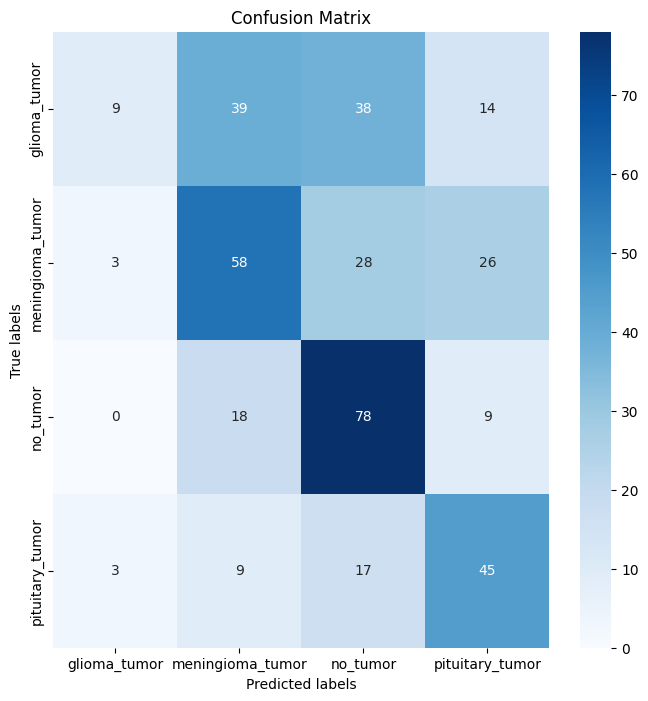


Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.60      0.09      0.16       100
meningioma_tumor       0.47      0.50      0.49       115
        no_tumor       0.48      0.74      0.59       105
 pituitary_tumor       0.48      0.61      0.54        74

        accuracy                           0.48       394
       macro avg       0.51      0.49      0.44       394
    weighted avg       0.51      0.48      0.44       394



In [25]:
# Évaluation sur l'ensemble de TEST (évaluation finale)
print(f"\n{'='*50}")
print(f"Évaluation FINALE sur l'ensemble de TEST")
print(f"{'='*50}\n")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Prédictions
y_test_pred = model.predict(X_test, verbose=0)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# F1-Score
f1_test = compute_f1_score(y_test, y_test_pred_classes)
print(f"F1-Score:      {f1_test:.4f}")

# Matrice de confusion
print("\nMatrice de confusion:")
plot_confusion_matrix(y_test, y_test_pred_classes, LABELS)

# Rapport de classification
print_classification_report(y_test, y_test_pred_classes, LABELS)

In [28]:
# Résumé des performances
# Retrieve validation metrics from history
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

# Calculate F1-Score for validation set
y_val_pred = model.predict(X_val, verbose=0)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
f1_val = compute_f1_score(y_val, y_val_pred_classes)

print(f"\n{'='*60}")
print(f"RÉSUMÉ DES PERFORMANCES - {model_name}")
print(f"{'='*60}")
print(f"\n{'Métrique':<20} {'Validation':<15} {'Test':<15}")
print(f"{'-'*50}")
print(f"{'Accuracy':<20} {val_acc*100:>6.2f}%        {test_acc*100:>6.2f}%")
print(f"{'F1-Score':<20} {f1_val:>6.4f}         {f1_test:>6.4f}")
print(f"{'Loss':<20} {val_loss:>6.4f}         {test_loss:>6.4f}")
print(f"{'='*60}\n")


RÉSUMÉ DES PERFORMANCES - CNN MRI

Métrique             Validation      Test           
--------------------------------------------------
Accuracy              66.55%         48.22%
F1-Score             0.6702         0.4410
Loss                 0.7460         2.2399



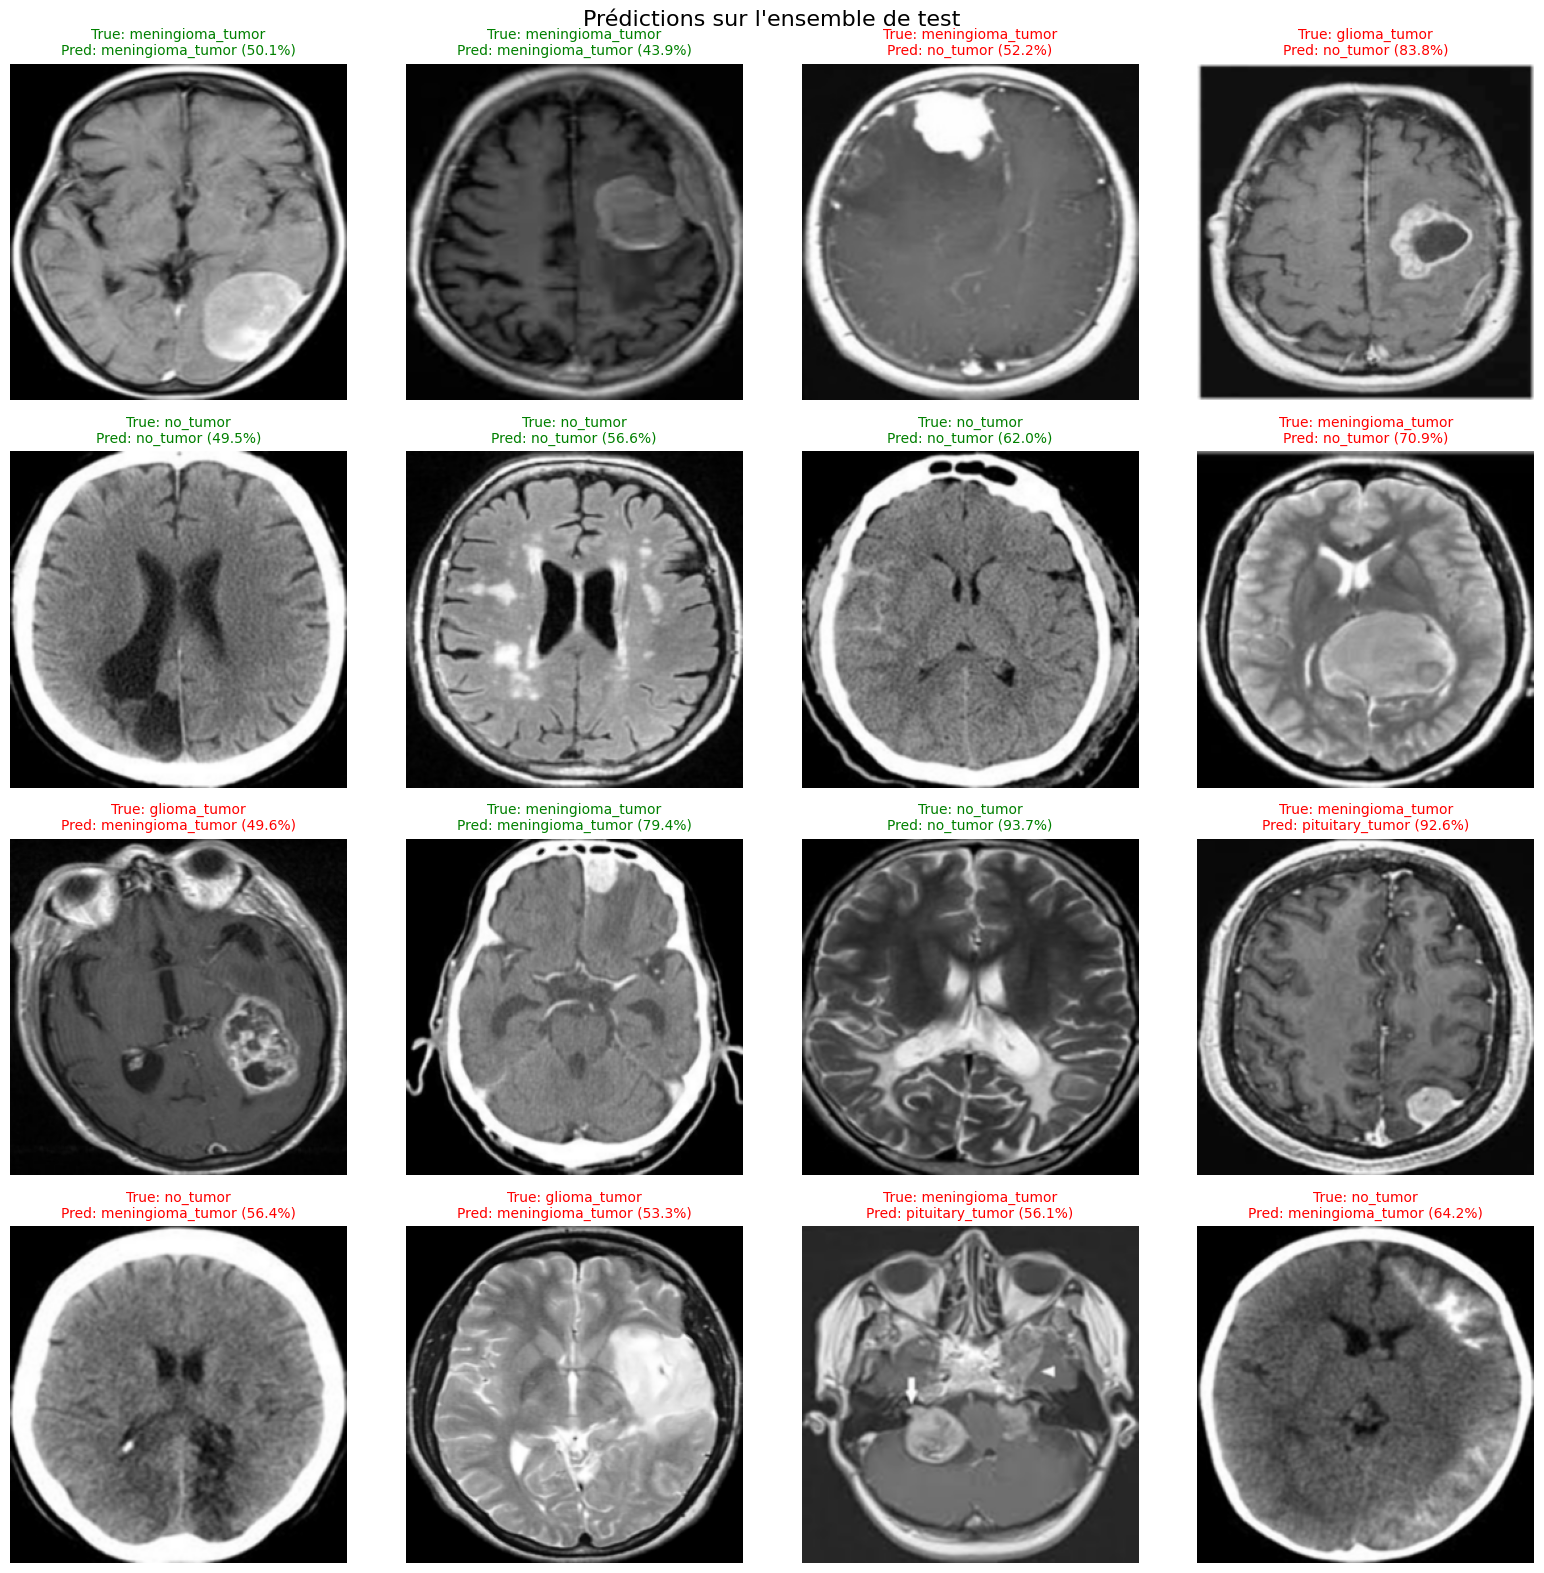


Prédictions correctes: 190/394 (48.22%)


In [29]:
# Visualiser quelques prédictions
num_samples = 16
indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle('Prédictions sur l\'ensemble de test', fontsize=16)

for idx, ax in enumerate(axes.flat):
    i = indices[idx]
    img = X_test[i]
    true_label = LABELS[y_test[i]]
    pred_label = LABELS[y_test_pred_classes[i]]
    confidence = y_test_pred[i][y_test_pred_classes[i]] * 100

    # Afficher l'image
    ax.imshow(img.astype('uint8'))

    # Couleur du titre selon si c'est correct ou non
    color = 'green' if true_label == pred_label else 'red'

    ax.set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)',
                 color=color, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Statistiques
correct = np.sum(y_test == y_test_pred_classes)
total = len(y_test)
print(f"\nPrédictions correctes: {correct}/{total} ({correct/total*100:.2f}%)")